In [1]:
import subtle.utils.io as suio
from subtle.subtle_preprocess import register_im
import SimpleITK as sitk

import numpy as np
import pydicom
from glob import glob

from intensity_normalization.normalize.zscore import ZScoreNormalize
zscore_norm = ZScoreNormalize()

import matplotlib.pyplot as plt

def nz_mean(arr):
#     return arr[np.nonzero(arr)].mean()
#     arr = zscore_norm(arr.ravel())
    return arr.ravel().mean()

def nz_std(arr):
#     return arr[np.nonzero(arr)].std()
#     arr = zscore_norm(arr.ravel())
    return arr.ravel().std()

def get_dicom_vol(dirpath_dicom):
    print('Getting dicom vol', dirpath_dicom)
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    dcm = pydicom.dcmread(dcm_files[0])
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

def get_boost_vols(dirpath_dicoms, norm=True, register=True):
    print('entering method')
    dcm_dirs = [d for d in glob('{}/*'.format(dirpath_dicoms))]
    dcm_dirs = sorted(dcm_dirs, key=lambda d: int(d.split('/')[-1].split('_')[0]))
    
    vols = [get_dicom_vol(d) for d in dcm_dirs]
    
    if register:
        pmap = sitk.GetDefaultParameterMap('affine')
        print('Registering post contrast...')
        vols[1], _ = register_im(vols[0], vols[1], param_map=pmap)
        print('Registering Gad Boost...')
        vols[2], _ = register_im(vols[0], vols[2], param_map=pmap)
        print('Registering Gad Boost MR...')
        vols[3], _ = register_im(vols[0], vols[3], param_map=pmap)
    
    if norm:
#         vols = [zscore_norm(v) for v in vols]
        vols = [v/v.mean() for v in vols]
    
    for idx, v in enumerate(vols):
        v[idx] = np.clip(v[idx], 0, v[idx].max())
        v[idx] = np.interp(v[idx], (v[idx].min(), v[idx].max()), (0, 1))
    
    return np.array(vols)

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [2]:
base_dir = '/home/srivathsa/projects/studies/gad/stanford/data/gad_mr/Patient_0399'
vols = get_boost_vols(base_dir)

entering method
Getting dicom vol /home/srivathsa/projects/studies/gad/stanford/data/gad_mr/Patient_0399/1_Ax_BRAVO_Pre_8
Getting dicom vol /home/srivathsa/projects/studies/gad/stanford/data/gad_mr/Patient_0399/2_Ax_BRAVO_+C_13
Getting dicom vol /home/srivathsa/projects/studies/gad/stanford/data/gad_mr/Patient_0399/3_Ax_BRAVO_Pre_GAD_1002
Getting dicom vol /home/srivathsa/projects/studies/gad/stanford/data/gad_mr/Patient_0399/6_Ax_BRAVO_+C_DNE_MRGADMR_1102
Registering post contrast...
image registration
registration done, 17.7 s
Registering Gad Boost...
image registration
registration done, 17.6 s
Registering Gad Boost MR...
image registration
registration done, 17.3 s


In [23]:
np.save('/home/srivathsa/projects/studies/gad/bracco/Patient_0399_boost.npy', vols)

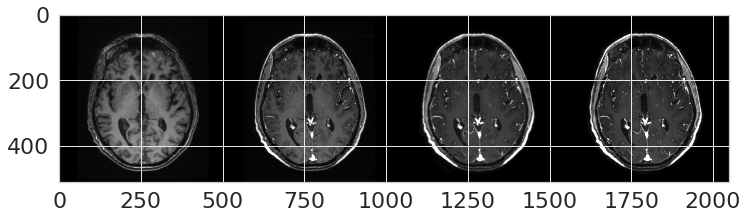

In [11]:
idx = 132

plt.imshow(np.hstack([vols[0, idx], vols[1, idx], vols[2, idx], vols[3, idx]]), vmax=10)
# plt.axis('off')

(-0.5, 599.5, 129.5, -0.5)

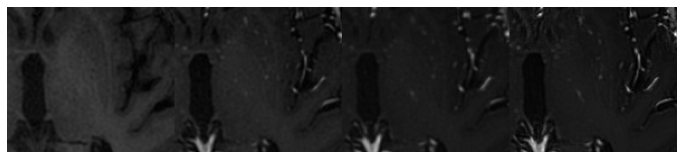

In [20]:
roi_pre, roi_post, roi_gb, roi_gbmr = vols[:, idx-2:idx+2, 200:330, 230:380]

plt.imshow(np.hstack([roi_pre[2], roi_post[2], roi_gb[2], roi_gbmr[2]]))
plt.axis('off')

In [ ]:
si_roi_pre = nz_mean(roi_pre)
si_roi_post = nz_mean(roi_post)
si_roi_gb = nz_mean(roi_gb)
si_roi_gbmr = nz_mean(roi_gbmr)

si_pre = nz_mean(vols[0])
si_post = nz_mean(vols[1])
si_gb = nz_mean(vols[2])
si_gbmr = nz_mean(vols[3])

sd_pre = nz_std(vols[0])
sd_post = nz_std(vols[1])
sd_gb = nz_std(vols[2])
sd_gbmr = nz_std(vols[3])

cnr_pre = (si_roi_pre - si_pre) / sd_pre
cnr_post = (si_roi_post - si_post) / sd_post
cnr_gb = (si_roi_gb - si_gb) / sd_gb
cnr_gbmr = (si_roi_gbmr - si_gbmr) / sd_gbmr

lbr_pre = si_roi_pre / si_pre
lbr_post = si_roi_post / si_post
lbr_gb = si_roi_gb / si_gb
lbr_gbmr = si_roi_gbmr / si_gbmr

cep_post = ((si_roi_post - si_roi_pre) / si_roi_pre) * 100
cep_gb = ((si_roi_gb - si_roi_pre) / si_roi_pre) * 100
cep_gbmr = ((si_roi_gbmr - si_roi_pre) / si_roi_pre) * 100

print(cnr_pre, cnr_post, cnr_gb)
print(lbr_pre, lbr_post, lbr_gb)
print(cep_post, cep_gb)

In [ ]:
print(vols[0].min(), vols[0].max())
print(vols[1].min(), vols[1].max())
print(vols[2].min(), vols[2].max())
print(vols[3].min(), vols[3].max())

In [ ]:
# Patient_0171 - 
# Patient_0187 - 163, 287:342 ,235:301
# Patient_0342 - 276, 338:376, 234:274
# Patient_0399 - 132, 320:335, 240:275
# Patient_0492 - 92, 151:243, 203:317